In [2]:
from analyze import analyze_data
from utils import RequestData
import json
from datetime import datetime
from zoneinfo import ZoneInfo
import numpy as np
import os
import re
exp_log_dir_map = {
    # "256-16": "/mnt/network_drive/lrq/logs/logs_2025-08-25-09-59-47/",
    "256-128": "/mnt/network_drive/lrq/logs/logs_2025-08-26-15-25-41/",
    "256-256": "/mnt/network_drive/lrq/logs/logs_2025-08-25-11-26-30/",
    "256-384": "/mnt/network_drive/lrq/logs/logs_2025-08-26-15-45-49/",
    "256-512": "/mnt/network_drive/lrq/logs/logs_2025-08-25-11-39-15/",
    # "1024-16": "/mnt/network_drive/lrq/logs/logs_2025-08-25-14-12-56/",
    "1024-128": "/mnt/network_drive/lrq/logs/logs_2025-08-26-17-05-17/",
    "1024-256": "/mnt/network_drive/lrq/logs/logs_2025-08-25-11-51-33/",
    "1024-384": "/mnt/network_drive/lrq/logs/logs_2025-08-26-16-29-27/",
    "1024-512": "/mnt/network_drive/lrq/logs/logs_2025-08-25-11-43-43/",
    # "8192-16": "/mnt/network_drive/lrq/logs/logs_2025-08-25-14-39-27/",
    "8192-128": "/mnt/network_drive/lrq/logs/logs_2025-08-26-16-42-28/",
    "8192-256": "/mnt/network_drive/lrq/logs/logs_2025-08-25-14-46-18/",
    "8192-384": "/mnt/network_drive/lrq/logs/logs_2025-08-26-17-18-27/",
    "8192-512": "/mnt/network_drive/lrq/logs/logs_2025-08-25-14-51-37/",
}
result_map = {}
BASE_RPS = 10
metrics_list = []
for experiment_label, exp_log_dir in exp_log_dir_map.items():
    if type(exp_log_dir) == str:
        result_map[experiment_label] = {}
        with open(f"{exp_log_dir}/sweep.json", 'r') as f:
            sweep_data = json.load(f)

        sampling_rates = sweep_data['loadgen_configs/loadgen_config.json::sampling_rate']
        rps = [BASE_RPS * rate / 100 for rate in sampling_rates]
        result_map[experiment_label] = {
            "rps": rps,
        }
    
    
        run_log_dirs = [os.path.join(exp_log_dir, entry.name) for entry in os.scandir(exp_log_dir) if entry.is_dir() and entry.name.startswith('run_')]
        run_log_dirs = sorted(run_log_dirs, key=lambda x: int(x.split('_')[-1]))
        print(run_log_dirs)
    else:
        run_log_dirs = exp_log_dir
        result_map[experiment_label] = {}
        sampling_rates = []
        for run_log_dir in run_log_dirs: 
            with open(f"{run_log_dir}/config.json", 'r') as f:
                config = json.load(f)
            sampling_rate = config['LLMLoadgen_config']['sampling_rate']
            sampling_rates.append(sampling_rate)
        rps = [BASE_RPS * rate / 100 for rate in sampling_rates]
        result_map[experiment_label] = {
            "rps": rps,
        }

    result_map[experiment_label]['finished_rates'] = []
    for run_log_dir in run_log_dirs:
        report_file_path = os.path.join(run_log_dir, 'report.json')
        if not os.path.exists(report_file_path):
            print(f"Report file not found for {run_log_dir}, analyzing data...")
            report_file_path = analyze_data(run_log_dir, metrics_list)

        with open(report_file_path, 'r') as f:
            report = json.load(f)

        loadgen_data = report['loadgen_data']


        start_str = report.get('router_start_time', 'N/A')
        end_str = report.get('router_end_time', 'N/A')
        tz_sg = ZoneInfo("Asia/Singapore")
        router_start_time = datetime.fromisoformat(start_str).replace(tzinfo=tz_sg).timestamp()
        router_end_time = datetime.fromisoformat(end_str).replace(tzinfo=tz_sg).timestamp()
        pattern = re.compile(r"^(\d{4}/\d{2}/\d{2} \d{2}:\d{2}:\d{2}) Finished preparing http requests")
        with open(f"{run_log_dir}/loadgen.err") as f:
            for line in f:
                m = pattern.match(line)
                if m:
                    dt = datetime.strptime(m.group(1), "%Y/%m/%d %H:%M:%S").replace(tzinfo=tz_sg)
                    break

        first_request_sendtime = dt.timestamp() + 5
        print(f"Router start time: {router_start_time}, end time: {router_end_time}")
        decode_times = []
        finished_tokens = []
        prefill_tokens = []
        decode_tokens = []
        tpots = []
        requests = []
        for request_data in loadgen_data:
            if 'error' in request_data:
                continue

            request = RequestData.init_from_dict(request_data)
            requests.append(request)

            arrival_time = request.arrival_time
            decode_finished_time = arrival_time + request.ttft + request.waiting_latency + request.decode_latency


            decode_times.append(decode_finished_time)
            finished_tokens.append(request.decode_tokens+request.prompt_tokens)
            prefill_tokens.append(request.prompt_tokens)
            decode_tokens.append(request.decode_tokens)
            tpot = request.decode_latency / request.decode_tokens if request.decode_tokens > 0 else 0
            tpots.append(tpot)

        assert len(decode_times) == len(finished_tokens)

        first_request_arrival_time = float('inf')
        last_request_finished_time = 0
        token_count = 0
        for request in requests:
            if request.arrival_time < first_request_arrival_time:
                first_request_arrival_time = request.arrival_time
            request_finished_time = request.arrival_time + request.ttft + request.waiting_latency + request.decode_latency
            if request_finished_time > last_request_finished_time:
                last_request_finished_time = request_finished_time
            token_count += request.prompt_tokens + request.decode_tokens
        avg_finished_rate = token_count / (last_request_finished_time - first_request_arrival_time)
        result_map[experiment_label]['finished_rates'].append(avg_finished_rate)
        print(f"Average finished rate: {avg_finished_rate} tokens/s")

    

['/mnt/network_drive/lrq/logs/logs_2025-08-26-15-25-41/run_0', '/mnt/network_drive/lrq/logs/logs_2025-08-26-15-25-41/run_1', '/mnt/network_drive/lrq/logs/logs_2025-08-26-15-25-41/run_2', '/mnt/network_drive/lrq/logs/logs_2025-08-26-15-25-41/run_3', '/mnt/network_drive/lrq/logs/logs_2025-08-26-15-25-41/run_4']
Router start time: 1756193177.948871, end time: 1756193506.673974
Average finished rate: 3778.4084856309096 tokens/s
Router start time: 1756193176.88484, end time: 1756193471.332007
Average finished rate: 11442.273399124324 tokens/s
Router start time: 1756193179.703518, end time: 1756193433.806401
Average finished rate: 18897.345697856726 tokens/s
Router start time: 1756193177.323035, end time: 1756193467.68178
Average finished rate: 13264.913933607053 tokens/s
Router start time: 1756193177.524753, end time: 1756193473.030355
Average finished rate: 14103.470075129595 tokens/s
['/mnt/network_drive/lrq/logs/logs_2025-08-25-11-26-30/run_0', '/mnt/network_drive/lrq/logs/logs_2025-08-2

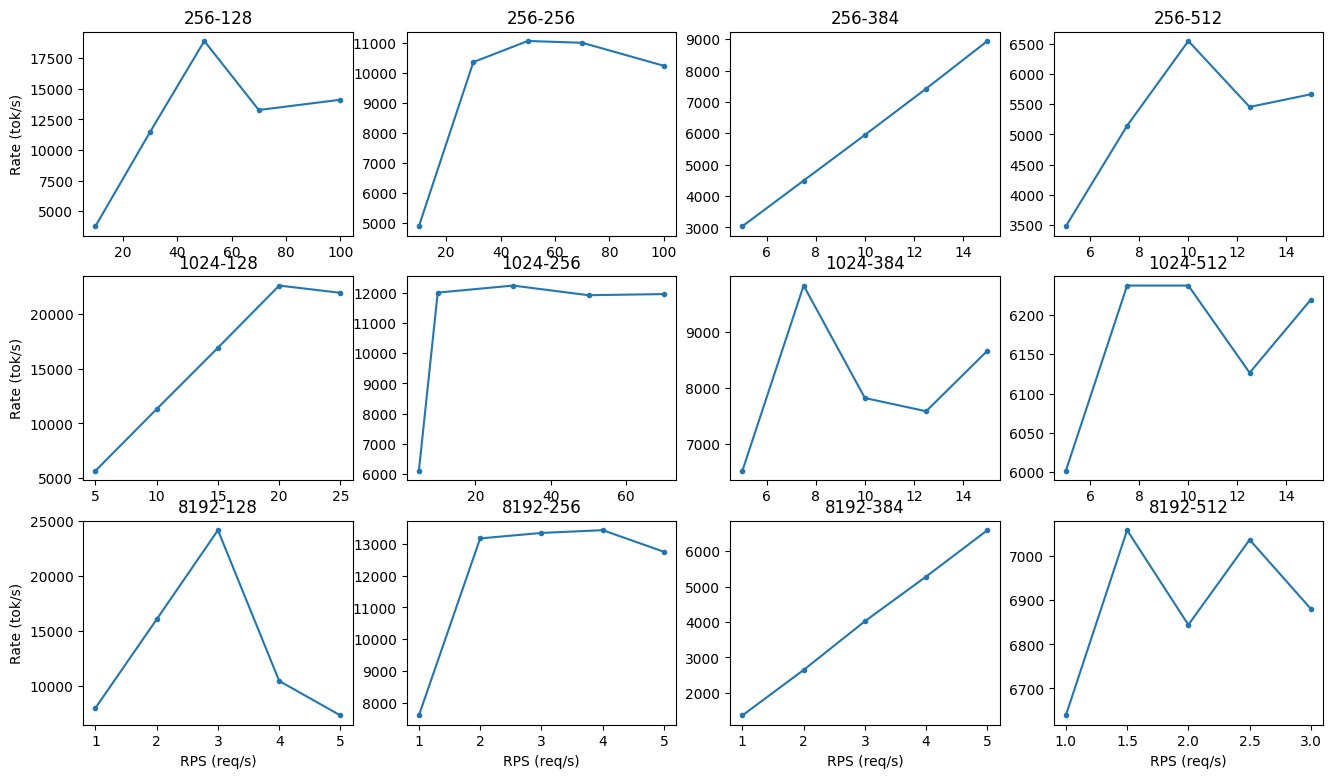

In [3]:
import matplotlib.pyplot as plt
inputs_list = []
outputs_list = []
for experiment_label, result in result_map.items():
    splits = experiment_label.split('-')
    if len(splits) == 2:
        input = int(splits[0])
        output = int(splits[1])
        if input not in inputs_list:
            inputs_list.append(input)
        if output not in outputs_list:
            outputs_list.append(output)

inputs = sorted(inputs_list)
outputs = sorted(outputs_list)

num_rows = len(inputs)
row_index_map = {}
for i, input in enumerate(inputs):
    row_index_map[input] = i

num_cols = len(outputs)
col_index_map = {}
for i, output in enumerate(outputs):
    col_index_map[output] = i

fig, axes = plt.subplots(num_rows, num_cols, figsize=(4*num_cols, 3*num_rows))
for experiment_label, result in result_map.items():
    splits = experiment_label.split('-')
    input = int(splits[0])
    output = int(splits[1])
    row_index = row_index_map[input]
    col_index = col_index_map[output]
    input, output = int(splits[0]), int(splits[1])
    row_index = row_index_map[int(experiment_label.split('-')[0])]
    axes[row_index][col_index].plot(result['rps'], result['finished_rates'], label="finished rates", marker='.')
    if row_index == len(inputs) - 1:
        axes[row_index][col_index].set_xlabel("RPS (req/s)")
    if col_index == 0:
        axes[row_index][col_index].set_ylabel("Rate (tok/s)")
    axes[row_index][col_index].set_title(experiment_label)


Input: 256, Output: 128, Finished Rate Capacity: 18897.3 tok/s
Input: 256, Output: 256, Finished Rate Capacity: 11067.3 tok/s
Input: 256, Output: 384, Finished Rate Capacity: 8941.2 tok/s
Input: 256, Output: 512, Finished Rate Capacity: 6549.0 tok/s
Input: 1024, Output: 128, Finished Rate Capacity: 22591.3 tok/s
Input: 1024, Output: 256, Finished Rate Capacity: 12242.5 tok/s
Input: 1024, Output: 384, Finished Rate Capacity: 9822.9 tok/s
Input: 1024, Output: 512, Finished Rate Capacity: 6237.3 tok/s
Input: 8192, Output: 128, Finished Rate Capacity: 24193.4 tok/s
Input: 8192, Output: 256, Finished Rate Capacity: 13422.3 tok/s
Input: 8192, Output: 384, Finished Rate Capacity: 6591.9 tok/s
Input: 8192, Output: 512, Finished Rate Capacity: 7059.3 tok/s


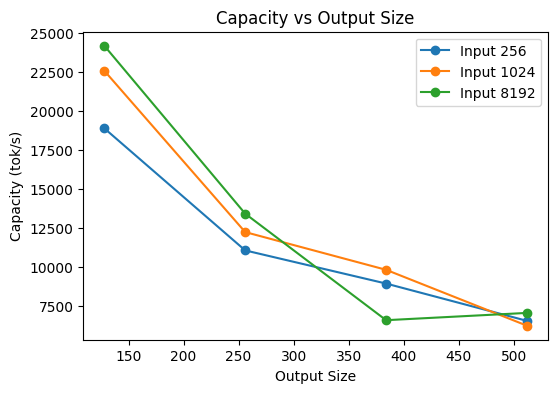

In [4]:

capacity_map = {}
for exp_label, result in result_map.items():
    splits = exp_label.split('-')
    input = int(splits[0])
    output = int(splits[1])
    capacity = max(result['finished_rates'])
    print(f"Input: {input}, Output: {output}, Finished Rate Capacity: {capacity:.1f} tok/s")
    if input not in capacity_map:
        capacity_map[input] = {}
        capacity_map[input]['outputs'] = []
        capacity_map[input]['capacities'] = []

    capacity_map[input]['outputs'].append(output)
    capacity_map[input]['capacities'].append(capacity)

plt.figure(figsize=(6, 4))
for input_size, data in capacity_map.items():
    outputs = data['outputs']
    capacities = data['capacities']
    plt.plot(outputs, capacities, marker='o', label=f"Input {input_size}")
    plt.xlabel("Output Size")
    plt.ylabel("Capacity (tok/s)")
    plt.title(f"Capacity vs Output Size")
    plt.legend()
# plt.ylim([0, 20000])
plt.show()

Input: 256, Output: 16, Theoretical Capacity: 130096.1 tok/s
Input: 256, Output: 128, Theoretical Capacity: 18972.2 tok/s
Input: 256, Output: 350, Theoretical Capacity: 8146.3 tok/s
Input: 256, Output: 610, Theoretical Capacity: 5138.6 tok/s
Input: 1024, Output: 16, Theoretical Capacity: 203809.8 tok/s
Input: 1024, Output: 128, Theoretical Capacity: 25983.2 tok/s
Input: 1024, Output: 350, Theoretical Capacity: 9794.8 tok/s
Input: 1024, Output: 610, Theoretical Capacity: 5766.5 tok/s
Input: 8192, Output: 16, Theoretical Capacity: 247116.4 tok/s
Input: 8192, Output: 128, Theoretical Capacity: 30902.4 tok/s
Input: 8192, Output: 350, Theoretical Capacity: 11310.4 tok/s
Input: 8192, Output: 610, Theoretical Capacity: 6495.3 tok/s


Text(0.5, 1.0, 'Theoretical Capacity vs Output Size')

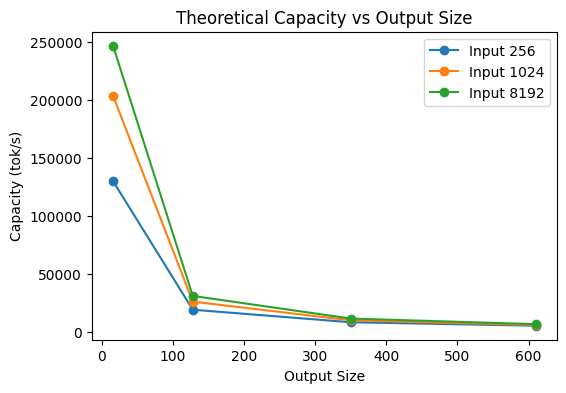

In [1]:
import matplotlib.pyplot as plt
a = 13.014 # ms
b = 0.000145831 # ms
c = 0.064 # ms
M = 16 * (1024**3) / (128 * 1024) # tok 
inputs = [256, 1024, 8192]
# outputs = [128, 256, 384, 512]
outputs = [16, 128, 350, 610]

def calculate_capacity(input_size, output_size):
    optimal_bsz = M / (input_size + output_size)
    e2e_latency_ms = 0 
    for o in range(output_size):
        # iter_latency = a + b * optimal_bsz * (input_size + o) + c * optimal_bsz # ms
        iter_latency = a + b * M + c * optimal_bsz # ms
        e2e_latency_ms += iter_latency
    e2e_latency_s = e2e_latency_ms / 1000 # convert to seconds
    decode_capacity = optimal_bsz* (input_size+output_size) / e2e_latency_s # tok/s
    return decode_capacity

plt.figure(figsize=(6, 4))
for input_size in inputs:
    decode_capcitys = []
    for output_size in outputs:
        capacity = calculate_capacity(input_size, output_size)
        print(f"Input: {input_size}, Output: {output_size}, Theoretical Capacity: {capacity:.1f} tok/s")
        decode_capcitys.append(capacity)

    plt.plot(outputs, decode_capcitys, marker='o', label=f"Input {input_size}")
plt.legend()
plt.xlabel("Output Size")
plt.ylabel("Capacity (tok/s)")
plt.title(f"Theoretical Capacity vs Output Size")
# plt.ylim(0, 20000)


    